In [3]:
from collections import defaultdict
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

import mazelab

import gym
from gym.spaces import Box
from gym.spaces import Discrete

from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3 import A2C, DQN, PPO

# Let's first train a policy on an empty environment.

In [7]:
GAMMA = 0.999

In [8]:
maze_env = gym.make("EmptyMaze-10x10-FixedGoal-v0")

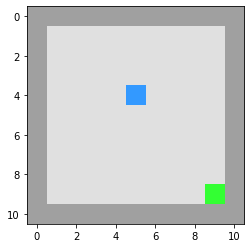

In [12]:
maze_env.reset()
plt.imshow(maze_env.get_image())

In [13]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)

In [14]:
model.learn(total_timesteps=50000, eval_env=maze_env, eval_freq=5000)

Eval num_timesteps=5000, episode_reward=-1.89 +/- 14.46
Episode length: 85.80 +/- 93.29
New best mean reward!
Eval num_timesteps=10000, episode_reward=9.94 +/- 0.03
Episode length: 6.60 +/- 3.32
New best mean reward!
Eval num_timesteps=15000, episode_reward=9.94 +/- 0.04
Episode length: 7.00 +/- 3.63
Eval num_timesteps=20000, episode_reward=9.92 +/- 0.04
Episode length: 8.80 +/- 3.71
Eval num_timesteps=25000, episode_reward=9.94 +/- 0.05
Episode length: 7.40 +/- 4.72
Eval num_timesteps=30000, episode_reward=9.93 +/- 0.04
Episode length: 8.00 +/- 3.69
Eval num_timesteps=35000, episode_reward=9.93 +/- 0.04
Episode length: 8.40 +/- 3.83
Eval num_timesteps=40000, episode_reward=9.92 +/- 0.03
Episode length: 8.60 +/- 2.94
Eval num_timesteps=45000, episode_reward=9.92 +/- 0.03
Episode length: 8.80 +/- 3.19
Eval num_timesteps=50000, episode_reward=9.95 +/- 0.02
Episode length: 6.40 +/- 1.62
New best mean reward!


In [17]:
images = []
for n in range(30):
    obs = maze_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v0-rollout.gif", width=110, height=110)

# Okay let's include maze walls

In [18]:
maze_env = gym.make("Maze-10x10-FixedGoal-v0")

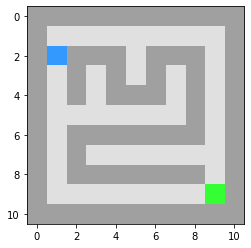

In [19]:
maze_env.reset()
plt.imshow(maze_env.get_image())

In [20]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)

In [21]:
model.learn(total_timesteps=500000, eval_env=maze_env, eval_freq=50000)

Eval num_timesteps=50000, episode_reward=9.88 +/- 0.04
Episode length: 13.40 +/- 3.72
New best mean reward!
Eval num_timesteps=100000, episode_reward=9.93 +/- 0.06
Episode length: 8.40 +/- 6.18
New best mean reward!
Eval num_timesteps=150000, episode_reward=7.55 +/- 4.77
Episode length: 46.00 +/- 77.10
Eval num_timesteps=200000, episode_reward=5.10 +/- 5.80
Episode length: 90.40 +/- 89.49
Eval num_timesteps=250000, episode_reward=2.78 +/- 5.85
Episode length: 122.40 +/- 95.07
Eval num_timesteps=300000, episode_reward=9.88 +/- 0.04
Episode length: 13.00 +/- 3.52
Eval num_timesteps=350000, episode_reward=-1.92 +/- 14.50
Episode length: 85.60 +/- 93.50
Eval num_timesteps=400000, episode_reward=1.62 +/- 11.68
Episode length: 82.20 +/- 96.19
Eval num_timesteps=450000, episode_reward=9.96 +/- 0.04
Episode length: 5.20 +/- 4.02
New best mean reward!
Eval num_timesteps=500000, episode_reward=9.92 +/- 0.05
Episode length: 8.60 +/- 4.76


In [24]:
images = []
for n in range(30):
    obs = maze_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-RandomMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-RandomMaze-v0-rollout.gif", width=110, height=110)

# It appears to hang out a bit at the bottom. Let's up the discount rate.

In [25]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=0.99)

In [26]:
model.learn(total_timesteps=200000, eval_env=maze_env, eval_freq=40000)

Eval num_timesteps=40000, episode_reward=-7.67 +/- 14.41
Episode length: 121.20 +/- 96.51
New best mean reward!
Eval num_timesteps=80000, episode_reward=7.54 +/- 4.77
Episode length: 47.20 +/- 76.49
New best mean reward!
Eval num_timesteps=120000, episode_reward=0.39 +/- 4.79
Episode length: 160.80 +/- 78.40
Eval num_timesteps=160000, episode_reward=9.90 +/- 0.05
Episode length: 11.40 +/- 5.20
New best mean reward!
Eval num_timesteps=200000, episode_reward=9.89 +/- 0.07
Episode length: 11.80 +/- 6.65


In [28]:
images = []
for n in range(30):
    obs = maze_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-RandomMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-RandomMaze-v0-rollout.gif", width=110, height=110)

In [29]:
model.learn?

In [30]:
PPO?

# Hmm let's add shaping and see if that helps

In [94]:
env = Env(Maze(x),
          randomize_start=False, 
          randomize_goal=False,
          shaping=True)
env_id = "RandomMaze-v2"

entry_point = lambda: env

gym.envs.register(id=env_id, entry_point=entry_point, max_episode_steps=200)

In [95]:
maze_env = gym.make("RandomMaze-v2")

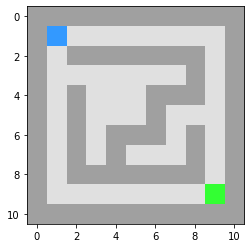

In [96]:
maze_env.reset()
plt.imshow(maze_env.get_image())

In [97]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)

In [98]:
model.learn(total_timesteps=50000, eval_env=maze_env, eval_freq=10000)

Eval num_timesteps=10000, episode_reward=-184.18 +/- 0.00
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-184.18 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=200.80 +/- 0.00
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=200.80 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=200.80 +/- 0.00
Episode length: 200.00 +/- 0.00


In [101]:
images = []
for n in range(10):
    obs = maze_env.reset()
    for _ in range(100):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-RandomMaze-v2-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-RandomMaze-v2-rollout.gif", width=110, height=110)

# Nah let's remove shaping

In [120]:
x = random_maze(width=10, height=10, complexity=0.7, density=0.5)
env = Env(Maze(x),
          randomize_start=False, 
          randomize_goal=False,
          shaping=False)
env_id = "RandomMaze-v4"

entry_point = lambda: env

gym.envs.register(id=env_id, entry_point=entry_point, max_episode_steps=200)

In [121]:
maze_env = gym.make("RandomMaze-v4")

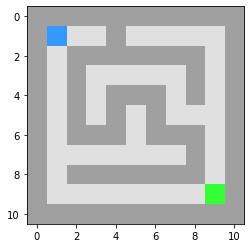

In [129]:
maze_env.reset()
plt.imshow(maze_env.get_image())

In [130]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)

In [131]:
model.learn(total_timesteps=100000, eval_env=maze_env, eval_freq=25000)

Eval num_timesteps=25000, episode_reward=99.85 +/- 0.00
Episode length: 16.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=-2.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=75000, episode_reward=99.85 +/- 0.00
Episode length: 16.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=-2.00 +/- 0.00
Episode length: 200.00 +/- 0.00


In [132]:
images = []
for n in range(10):
    obs = maze_env.reset()
    for _ in range(100):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-RandomMaze-v2-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-RandomMaze-v2-rollout.gif", width=110, height=110)

# Let's allow for the randomization of starting position.

In [36]:
class DynamicEnv(BaseEnv):
    def __init__(self, maze, start_pos=None, goal_pos=None):
        super().__init__()
        
        self.maze = maze
        self.motions = VonNeumannMotion()
        
        w, h = self.maze.size
        if start_pos is None: self.start_pos = [1, 1]
        else:                 self.start_pos = start_pos
        if goal_pos is None:  self.goal_pos = [w-2, h-2]
        else:                 self.goal_pos = goal_pos
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +10
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        
        d_s0 = manhattan_distance(current_position, self.maze.objects.goal.positions[0])
        d_s1 = manhattan_distance(new_position, self.maze.objects.goal.positions[0])
        shaping = GAMMA*(-d_s1) - (-d_s0)
        
        return self.maze.to_value(), reward + shaping, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = [list(random.choice(self.maze.objects.free.positions))]
        self.maze.objects.goal.positions = [self.goal_pos]
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()


In [39]:
x = random_maze(width=10, height=10, complexity=0.7, density=0.5)
env = DynamicEnv(Maze(x))
env_id = "DynamicRandomMaze-v1"

entry_point = lambda: env

gym.envs.register(id=env_id, entry_point=entry_point, max_episode_steps=200)

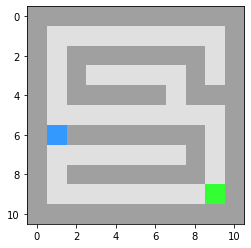

In [67]:
maze_env = gym.make("DynamicRandomMaze-v1")
maze_env.reset()
plt.imshow(maze_env.get_image())

In [68]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)
model.learn(total_timesteps=200000, eval_env=maze_env, eval_freq=40000)

Eval num_timesteps=40000, episode_reward=11.18 +/- 4.44
Episode length: 42.60 +/- 78.72
New best mean reward!
Eval num_timesteps=80000, episode_reward=11.42 +/- 8.07
Episode length: 84.60 +/- 94.26
New best mean reward!
Eval num_timesteps=120000, episode_reward=10.65 +/- 5.30
Episode length: 82.80 +/- 95.71
Eval num_timesteps=160000, episode_reward=4.39 +/- 5.83
Episode length: 161.20 +/- 77.60
Eval num_timesteps=200000, episode_reward=7.10 +/- 5.63
Episode length: 121.60 +/- 96.02


In [74]:
images = []
for n in range(10):
    obs = maze_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/A2C-DynamicRandomMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/A2C-DynamicRandomMaze-v1-rollout.gif", width=110, height=110)

In [75]:
model.learn(total_timesteps=400000, eval_env=maze_env, eval_freq=40000)

Eval num_timesteps=40000, episode_reward=4.59 +/- 4.32
Episode length: 160.60 +/- 78.80
New best mean reward!
Eval num_timesteps=80000, episode_reward=9.71 +/- 7.27
Episode length: 83.00 +/- 95.59
New best mean reward!
Eval num_timesteps=120000, episode_reward=9.62 +/- 6.88
Episode length: 82.80 +/- 95.74
Eval num_timesteps=160000, episode_reward=8.59 +/- 5.64
Episode length: 81.80 +/- 96.52
Eval num_timesteps=200000, episode_reward=2.06 +/- 1.80
Episode length: 200.00 +/- 0.00
Eval num_timesteps=240000, episode_reward=6.74 +/- 6.85
Episode length: 122.00 +/- 95.54
Eval num_timesteps=280000, episode_reward=5.71 +/- 8.66
Episode length: 162.60 +/- 74.80
Eval num_timesteps=320000, episode_reward=-74.55 +/- 160.59
Episode length: 160.60 +/- 78.80
Eval num_timesteps=360000, episode_reward=10.50 +/- 6.73
Episode length: 83.00 +/- 95.59
New best mean reward!
Eval num_timesteps=400000, episode_reward=12.89 +/- 7.94
Episode length: 48.20 +/- 76.20
New best mean reward!


In [77]:
images = []
for n in range(10):
    obs = maze_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/A2C-DynamicRandomMaze-v1-rollout2.gif', images, fps=29)
Image(filename=f"tmp/A2C-DynamicRandomMaze-v1-rollout2.gif", width=110, height=110)

# Let's try a larger maze

In [78]:
x = random_maze(width=20, height=20, complexity=0.7, density=0.5)
env = DynamicEnv(Maze(x))
env_id = "LargerDynamicRandomMaze-v0"

entry_point = lambda: env

gym.envs.register(id=env_id, entry_point=entry_point, max_episode_steps=200)

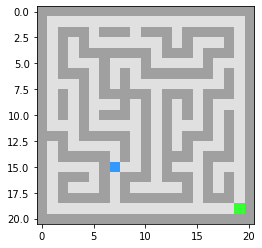

In [88]:
maze_env = gym.make("LargerDynamicRandomMaze-v0")
maze_env.reset()
plt.imshow(maze_env.get_image())

In [89]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)
model.learn(total_timesteps=600000, eval_env=maze_env, eval_freq=50000)

Eval num_timesteps=50000, episode_reward=-156.96 +/- 196.73
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=-154.45 +/- 195.23
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=150000, episode_reward=-145.14 +/- 182.31
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=200000, episode_reward=5.04 +/- 1.38
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=250000, episode_reward=-149.06 +/- 190.82
Episode length: 160.20 +/- 79.60
Eval num_timesteps=300000, episode_reward=-147.11 +/- 191.65
Episode length: 161.60 +/- 76.80
Eval num_timesteps=350000, episode_reward=8.34 +/- 2.08
Episode length: 160.20 +/- 79.60
New best mean reward!
Eval num_timesteps=400000, episode_reward=-75.53 +/- 160.78
Episode length: 200.00 +/- 0.00
Eval num_timesteps=450000, episode_reward=-73.93 +/- 162.17
Episode length: 200.00 +/- 0.00
Eval num_timesteps=500000, episode_reward=7.31 +/- 6.96
Episode

In [90]:
images = []
for n in range(10):
    obs = maze_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/A2C-LargerDynamicRandomMaze-v1-rollout2.gif', images, fps=29)
Image(filename=f"tmp/A2C-LargerDynamicRandomMaze-v1-rollout2.gif", width=110, height=110)

# Hmm so scaling to a larger maze is going to be tricky. Let's go back down to a smaller size, but also randomize the goal position

In [138]:
class DoubleDynamicEnv(BaseEnv):
    def __init__(self, maze, start_pos=None, goal_pos=None):
        super().__init__()
        
        self.maze = maze
        self.motions = VonNeumannMotion()
        
        w, h = self.maze.size
        if start_pos is None: self.start_pos = [1, 1]
        else:                 self.start_pos = start_pos
        if goal_pos is None:  self.goal_pos = [w-2, h-2]
        else:                 self.goal_pos = goal_pos
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +10
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        
#         d_s0 = manhattan_distance(current_position, self.maze.objects.goal.positions[0])
#         d_s1 = manhattan_distance(new_position, self.maze.objects.goal.positions[0])
#         shaping = GAMMA*(-d_s1) - (-d_s0)
        shaping = 0
        
        return self.maze.to_value(), reward + shaping, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = [list(random.choice(self.maze.objects.free.positions))]
        self.maze.objects.goal.positions = [list(random.choice(self.maze.objects.free.positions))]
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()


In [139]:
x = random_maze(width=10, height=10, complexity=0.8, density=0.5)
env = DoubleDynamicEnv(Maze(x))
env_id = "DoubleDynamicRandomMaze-v2"

entry_point = lambda: env

gym.envs.register(id=env_id, entry_point=entry_point, max_episode_steps=200)

In [140]:
maze_env = gym.make("DoubleDynamicRandomMaze-v2")

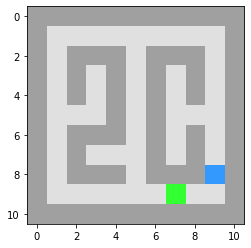

In [152]:
maze_env.reset()
plt.imshow(maze_env.get_image())

In [153]:
model = PPO('MlpPolicy', maze_env, verbose=0, gamma=GAMMA)
model.learn(total_timesteps=1000000, eval_env=maze_env, eval_freq=50000)

Eval num_timesteps=50000, episode_reward=-38.41 +/- 78.95
Episode length: 160.20 +/- 79.60
New best mean reward!
Eval num_timesteps=100000, episode_reward=-41.40 +/- 78.80
Episode length: 200.00 +/- 0.00
Eval num_timesteps=150000, episode_reward=-159.01 +/- 78.55
Episode length: 200.00 +/- 0.00
Eval num_timesteps=200000, episode_reward=-120.21 +/- 96.52
Episode length: 200.00 +/- 0.00
Eval num_timesteps=250000, episode_reward=-120.40 +/- 96.68
Episode length: 200.00 +/- 0.00
Eval num_timesteps=300000, episode_reward=-158.42 +/- 78.24
Episode length: 200.00 +/- 0.00
Eval num_timesteps=350000, episode_reward=-155.43 +/- 82.73
Episode length: 160.80 +/- 78.40
Eval num_timesteps=400000, episode_reward=-39.21 +/- 80.53
Episode length: 160.80 +/- 78.40
Eval num_timesteps=450000, episode_reward=-80.41 +/- 96.03
Episode length: 200.00 +/- 0.00
Eval num_timesteps=500000, episode_reward=-120.21 +/- 96.52
Episode length: 200.00 +/- 0.00
Eval num_timesteps=550000, episode_reward=-158.82 +/- 78.41


In [157]:
images = []
for n in range(10):
    obs = maze_env.reset()
    for _ in range(100):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = maze_env.step(action)
        if done:
            break
        frame = maze_env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/A2C-DoubleDynamicRandomMaze-v1-rollout2.gif', images, fps=29)
Image(filename=f"tmp/A2C-DoubleDynamicRandomMaze-v1-rollout2.gif", width=110, height=110)